# Macroeconomic dashboard

Alex Wellman, October 2023

# European Data 

Background Code

In [8]:
# Import packages 

import pandas as pd
import requests
from io import StringIO
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import imgkit

In [9]:
# Define the base path for saving and displaying files

base_path = "/Users/awellman/Documents/GitHub/macrodata-wellman/figures/"

# Global dictionary to hold dataframes in memory
datasets = {}


In [10]:
# Collect and plot data

def fetch_and_plot(url_template, countries, plot_title, frequency, x_label, y_label, manipulations):

    # Check if any manipulations are provided and construct the full title
    if isinstance(manipulations, str):
        if manipulations == "":
            manipulations = []
        else:
            manipulations = [manipulations]

    # Check if any manipulations are provided and construct the full title
    if len(manipulations) > 0:
        # Format manipulation names to be more readable
        manipulation_texts = " ".join(manipulations)
        manipulation_texts = manipulation_texts.replace('_', ' ').lower()
        full_title = f"{plot_title} (Manipulated: {manipulation_texts})"
    else:
        full_title = plot_title


    # File paths for table and plot
    table_filename_html = f"{base_path}{full_title.replace(' ', '_')}_table.html"
    table_filename_png = f"{base_path}{full_title.replace(' ', '_')}_table.png"
    plot_filename = f"{base_path}{full_title.replace(' ', '_')}_plot.png"

    # Create an empty DataFrame to store the results
    df_collect = pd.DataFrame()

    # Initialize a list to store DataFrame rows for the summary table
    summary_rows = []

    # Loop through the countries and extract data
    for country_code, country_name in countries.items():
        # Format the URL with the country code
        url = url_template.format(country_code=country_code)
        response = requests.get(url)

        # Check if the data is found for the country
        if response.status_code != 200:
            print(f"Data not found for {country_name} ({country_code}).")
            continue

        df_country = pd.read_csv(StringIO(response.text), sep='\t')

        # Select the data column assuming it's the second one
        data_columns = df_country.columns[1:]

        # Append the data for the current country to the main DataFrame
        df_collect[country_name] = df_country[data_columns].iloc[0]

    # Replace ':' and any trailing spaces with NaN for missing values
    df_collect.replace(': ?', pd.NA, regex=True, inplace=True)

    # Ensure that the index is a string and strip any whitespace that might cause parsing issues
    df_collect.index = df_collect.index.astype(str).str.strip()

    # Convert index to DateTime
    if frequency == 'Q':
        df_collect.index = pd.PeriodIndex(df_collect.index, freq='Q').to_timestamp()
    elif frequency == 'M':
        df_collect.index = pd.PeriodIndex(df_collect.index, freq='M').to_timestamp()

    # Replace '<NA>' with np.nan and remove ' p' from the data
    df_collect = df_collect.replace({ '<NA>': np.nan, ' p': '' }, regex=True)

    # Convert the index to a datetime format if it's not already
    df_collect.index = pd.to_datetime(df_collect.index)

    # Filter the DataFrame to include data from 1995 onwards
    df_collect = df_collect[df_collect.index.year >= 1995]

    # Convert all data to numeric, coercing errors to NaN
    for column in df_collect.columns:
        df_collect[column] = pd.to_numeric(df_collect[column], errors='coerce')

    # Perform data manipulation if required
    if len(manipulations) > 0:
        for manipulation in manipulations:
            if manipulation in data_manipulations:
                manipulation_function = data_manipulations[manipulation]
                df_collect = manipulation_function(df_collect)

    # Add the final dataset to the dictionary for later use
    datasets[full_title] = df_collect.copy()
    
    # Accumulate data for summary table
    for country in df_collect.columns:
        recent_data = df_collect[country].dropna()
        if not recent_data.empty:
            recent_date = recent_data.index[-1]
            recent_value = recent_data.iloc[-1]
            previous_year_date = recent_date - pd.DateOffset(years=1)
            previous_year_value = df_collect[country].get(previous_year_date, "N/A")

            # Add a new row to the summary_rows list
            summary_rows.append({
                "Country": country,
                "Most Recent Date": recent_date.date(),
                "Most Recent Value": recent_value,
                "Previous Year Date": previous_year_date.date(),
                "Previous Year Value": previous_year_value
            })

    # Create the summary DataFrame using concat
    summary_table = pd.concat([pd.DataFrame([row]) for row in summary_rows], ignore_index=True)

    # Styling the DataFrame for a cleaner look
    styled_table = summary_table.style.format({
        "Most Recent Value": "{:.2f}",
        "Previous Year Value": "{:.2f}"
    }).set_table_styles([
        {'selector': 'th', 'props': [('font-size', '12pt'), ('text-align', 'center'), ('border-right', '1px solid black')]},
        {'selector': 'td', 'props': [('font-size', '12pt'), ('text-align', 'center'), ('border-right', '1px solid black')]},
        {'selector': 'tr:nth-child(1) th', 'props': [('border-bottom', '2px solid black')]}  # Horizontal line below the first row
    ]).hide(axis='index').set_caption(f"<b style='font-size: 16pt;'>{full_title}</b>")

    # Save and display table as PNG
    table_html = styled_table.to_html()
    with open(table_filename_html, 'w') as f:
        f.write(table_html)
    imgkit.from_file(table_filename_html, table_filename_png)
    display(Image.open(table_filename_png))
    
    # Plotting and saving plot as PNG
    plt.figure(figsize=(14, 7))
    for column in df_collect.columns:
        plt.plot(df_collect.index, df_collect[column], label=column)

    plt.title(full_title)
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()

    # Save the plot as PNG
    plt.savefig(plot_filename)
    plt.close()
    display(Image.open(plot_filename))


Define Countries

In [11]:
# Define your countries 

countries = {
    'FR': 'France',
    'DE': 'Germany',
    'IT': 'Italy',
    'EA': 'Euro Area',
    'UK': 'UK', 
}

Define potential manipulations to the data

In [22]:
# Define manipulations

data_manipulations = {
    'multiply_100': lambda df: df * 100,
    'log_scale': lambda df: np.log(df) * 100,
    'yoy_change': lambda df: df.pct_change(periods=12) *100
    # Add more manipulation functions as needed
}

Define Data

In [29]:
# Legend
    # SCA = seasonally and calendar adjusted
    # PCH_SM = Percentage change compared to same period in previous year 
    # Q = Quarterly
    # M = Monthly
    # PC_ACT = Percentage of active population (Labor Force)

    # Manipulation Options 

    # multiply_100 = multiply all x values by 100
    # log_scale = log scale all x  values
    # yoy_change = percent change from previous year
    # "" = no manipulation

    # EXAMPLE W/ TWO DATA MANIPULATIONS

    # Example: ("url", "Title", 'Q', "X-axis Label", "Y-axis Label",["yoy_change", "multiply_100"])

urls_and_titles = [
    (
        "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/namq_10_lp_ulc/Q.I10.SCA.RLPR_HW.{country_code}?format=TSV", #url
        "Labor Productivity Per Hour Worked", #title
        'Q', #frequency of data 
        "Year", #x_label
        "", #y_label
        "" #manipulationa
    ),
    (
        "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/namq_10_lp_ulc/Q.I10.SCA.RLPR_Per.{country_code}?format=TSV",
        "Labor Productivity Per Person Employed",
        'M',
        "Year", 
        "",
        ""
    ),
    (
        "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/ei_lmhr_m/M.PC_ACT.SA.LM-UN-T-TOT.{country_code}?format=TSV", 
        "Overall Unemployment Rate",
        'M',
        "Year", 
        "",
        ""
    ),
    (
        "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/prc_hicp_midx/M.I05.CP00.{country_code}?format=TSV",
        "HICP",
        'M',
        "Year",
        "",
        ["yoy_change" , "multiply_100"]
    ),
    (
        "https://ec.europa.eu/eurostat/api/dissemination/sdmx/2.1/data/ei_lmhr_m/M.PC_ACT.SA.LM-UN-T-LE25.{country_code}?format=TSV", 
        "Youth Unemployment Rate",
        'M',
        "Year", 
        "",
        ""
    ),
]

Create Figures

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


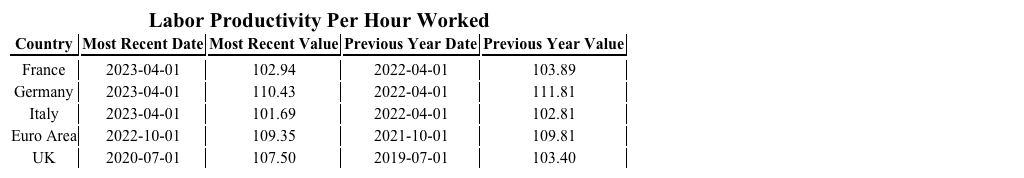

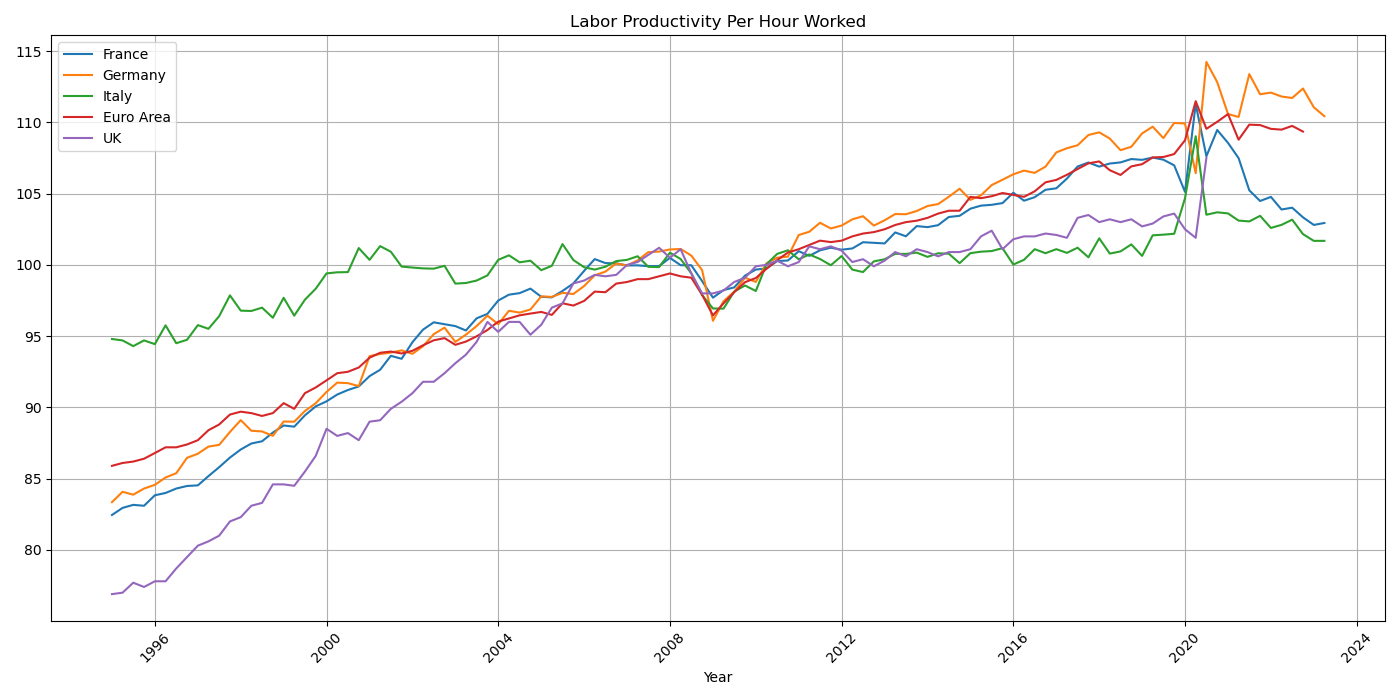

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


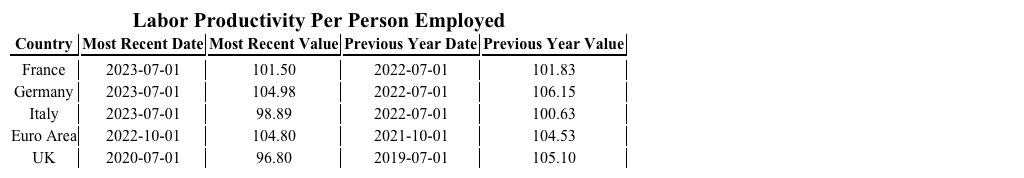

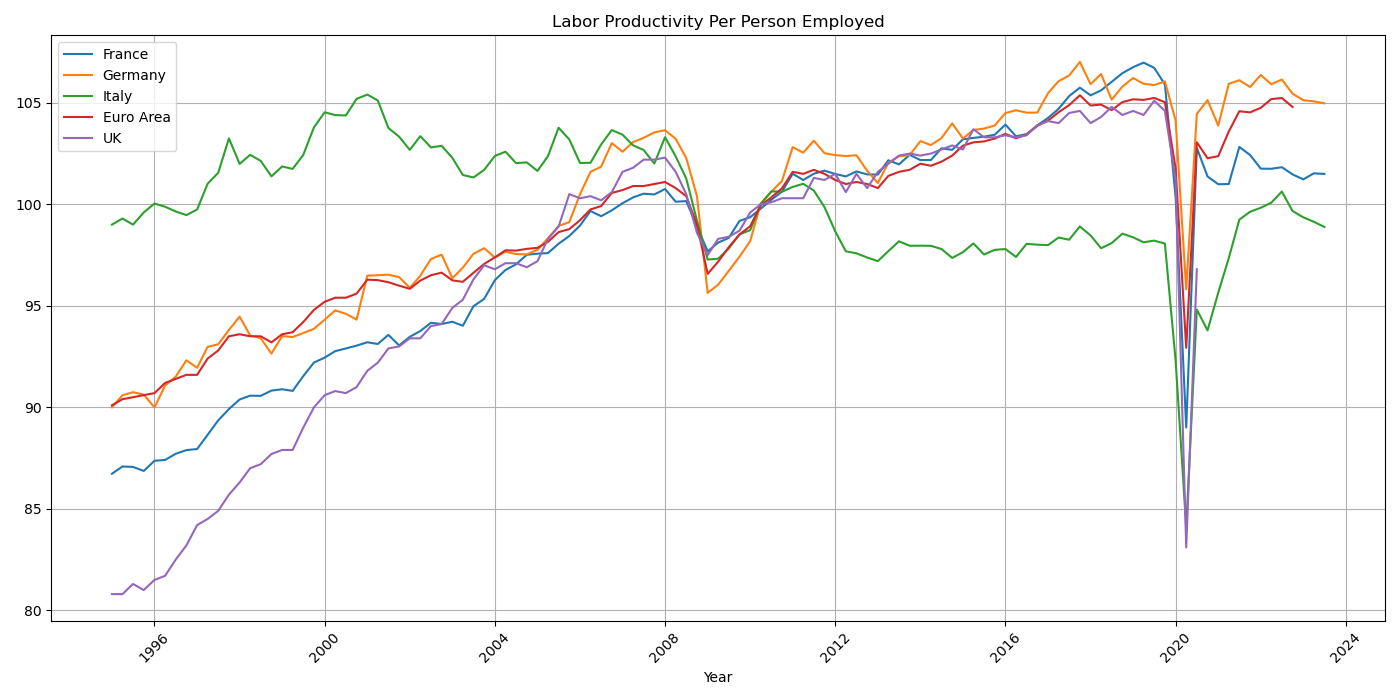

Data not found for Euro Area (EA).
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


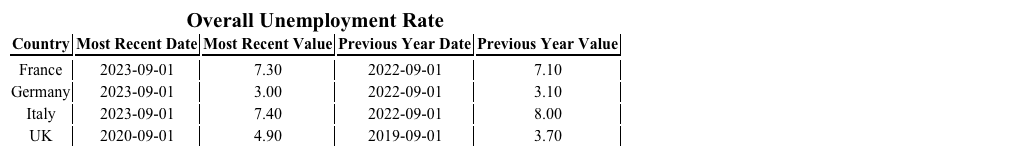

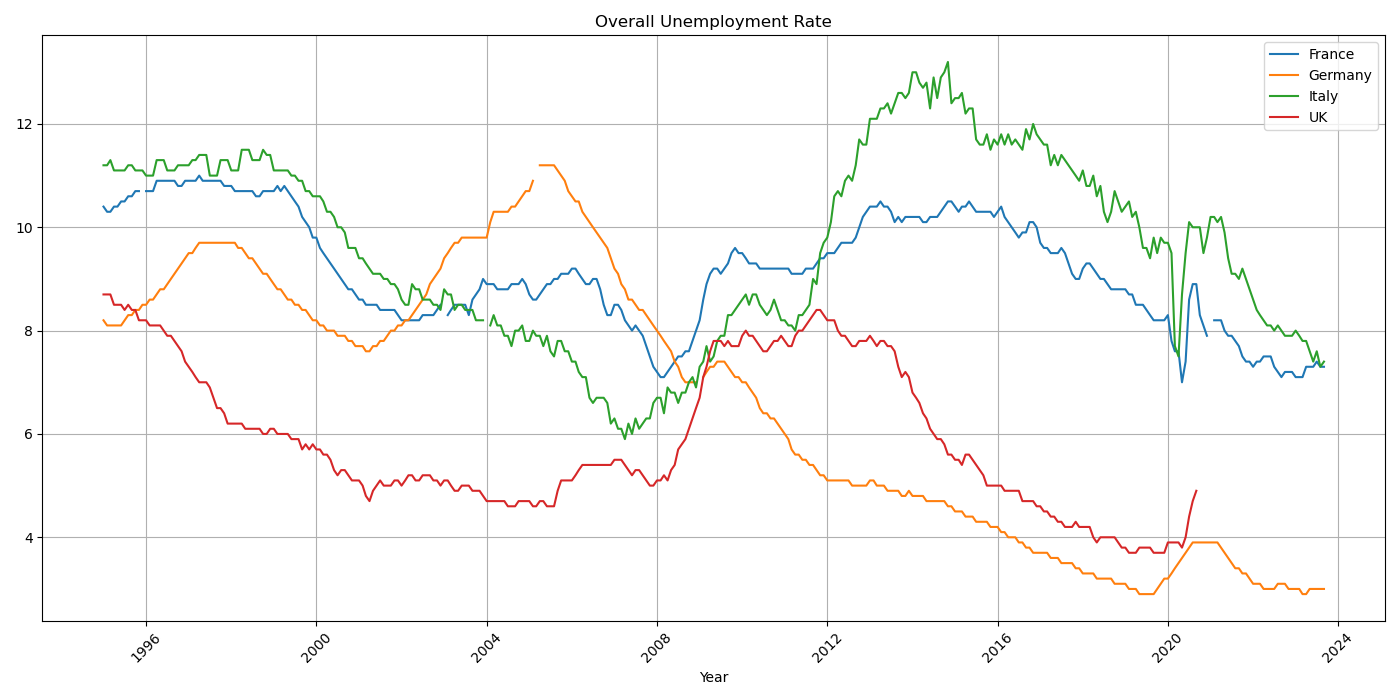

Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


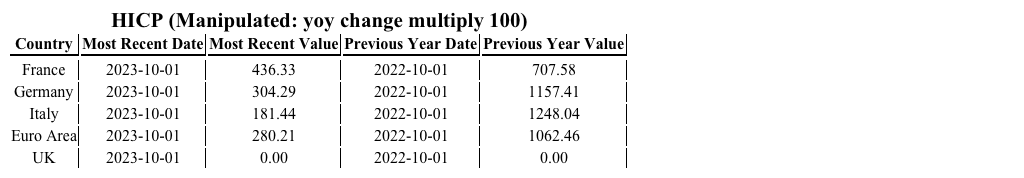

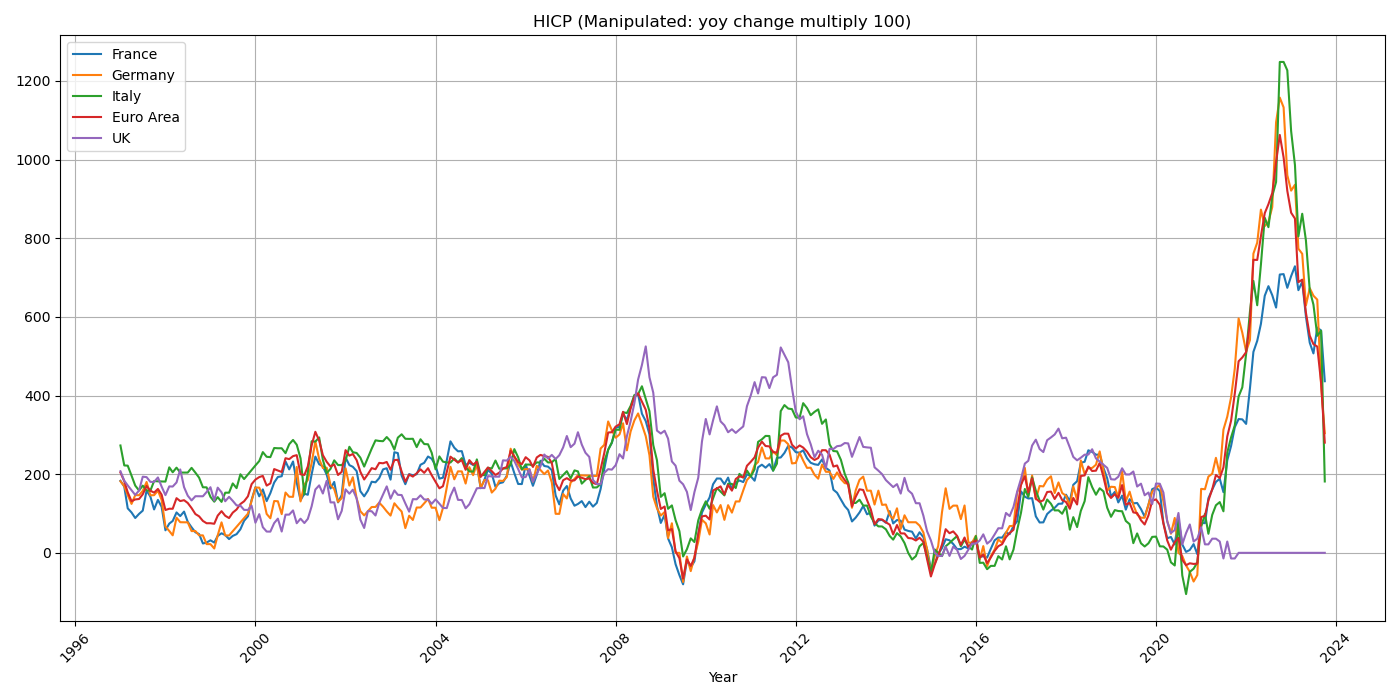

Data not found for Euro Area (EA).
Loading page (1/2)
Rendering (2/2)                                                    
Done                                                               


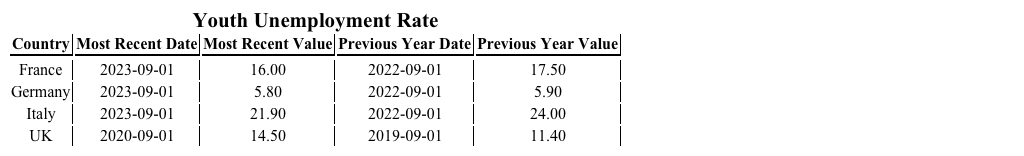

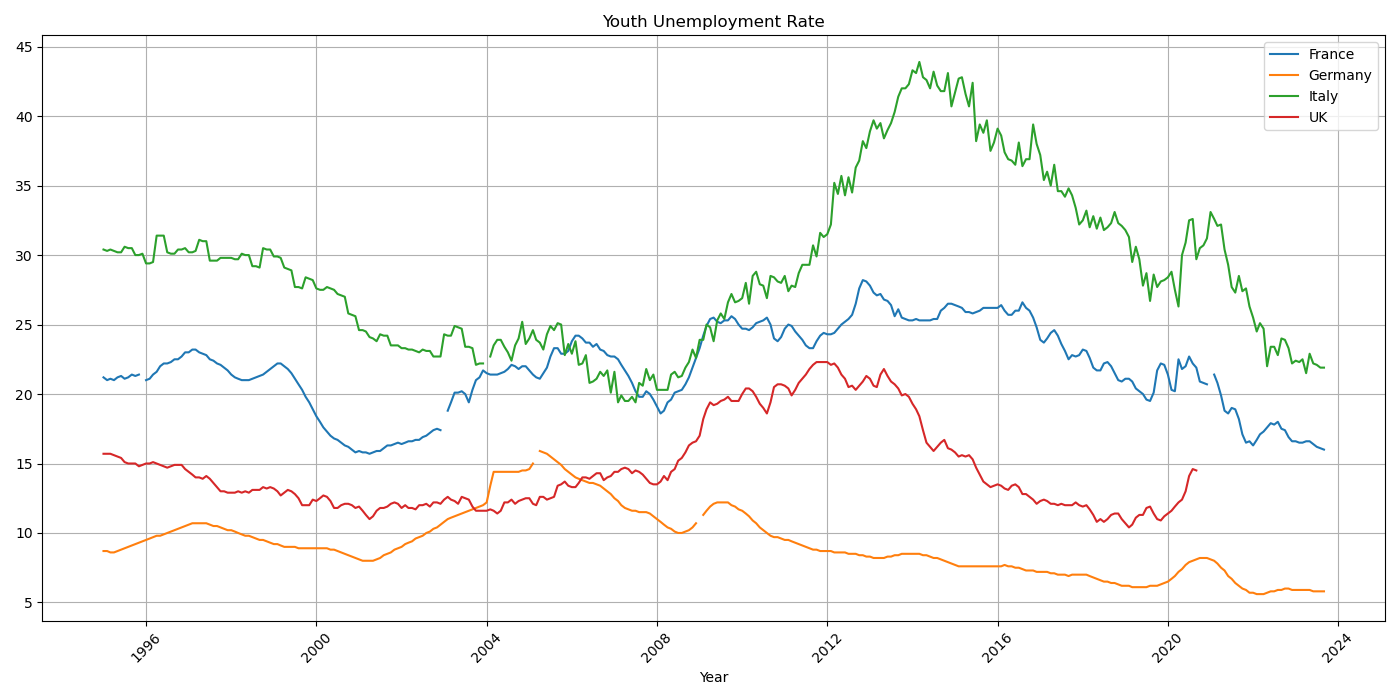

In [30]:
# Loop through the URLs and plot the data
for url_template, title, frequency, x_label, y_label, manipulation in urls_and_titles:
    fetch_and_plot(url_template, countries, title, frequency, x_label, y_label, manipulation)

Manipulate Figures

In [15]:
# Operations and list of datasets functions

operations = {
    'divide': lambda dataset1, dataset2, dataset3: dataset1.div(dataset2),
    'multiply': lambda dataset1, dataset2, dataset3: dataset1.multiply(dataset2),
    'multiply3': lambda dataset1, dataset2, dataset3: dataset1.multiply(dataset2).multiply(dataset3)    # Add more operations here if needed
}


In [31]:
# list of datasets currectly available

def list_dataset_names(datasets):
    dataset_names = datasets.keys()
    print("Currently stored datasets:")
    for name in dataset_names:
        print(name)

list_dataset_names(datasets)

Currently stored datasets:
Labor Productivity Per Hour Worked
Labor Productivity Per Person Employed
Overall Unemployment Rate
HICP (Manipulated: yoy change)
Youth Unemployment Rate
Labor Productivity Per Hour Worked (Manipulated: log scale)
HICP (Manipulated: yoy change multiply 100)


In [17]:
# Apply operation for plot

def manipulate_and_plot(datasets, dataset1_key, dataset2_key, dataset3_key, operation_name, plot_title, x_label, y_label):
    dataset1 = datasets.get(dataset1_key)
    dataset2 = datasets.get(dataset2_key)
    dataset3 = datasets.get(dataset3_key) if dataset3_key else None

    operation = operations.get(operation_name)

    # Check for too many arguments for 'divide' and 'multiply'
    if operation_name in ['divide', 'multiply'] and dataset3 is not None:
        print(f"'{operation_name}' operation does not support three arguments. Too many arguments.")
        return


    if dataset1 is not None and dataset2 is not None and operation is not None:
        result = operation(dataset1, dataset2, dataset3)

        if result is not None:
            plt.figure(figsize=(14, 7))
            for column in result.columns:
                plt.plot(result.index, result[column], label=column)

            plt.title(plot_title)
            plt.xlabel(x_label)
            plt.ylabel(y_label)
            plt.legend()
            plt.grid(True)
            plt.xticks(rotation=45)
            plt.tight_layout()
            plt.show()

            # Detailed description of the operation performed
            operation_description = {
                'divide': f"'{dataset1_key}' divided by '{dataset2_key}'",
                'multiply': f"'{dataset1_key}' multiplied by '{dataset2_key}'",
                'multiply3': f"'{dataset1_key}', '{dataset2_key}', and '{dataset3_key}' all multiplied together"
            }

            description = operation_description.get(operation_name, "Operation description not available.")
            print(f"Operation '{operation_name}' performed: {description}.")
        else:
            print("Operation result is None, no plot generated.")
    else:
        print("Datasets not found or unsupported operation.")



'divide' operation does not support three arguments. Too many arguments.
'multiply' operation does not support three arguments. Too many arguments.


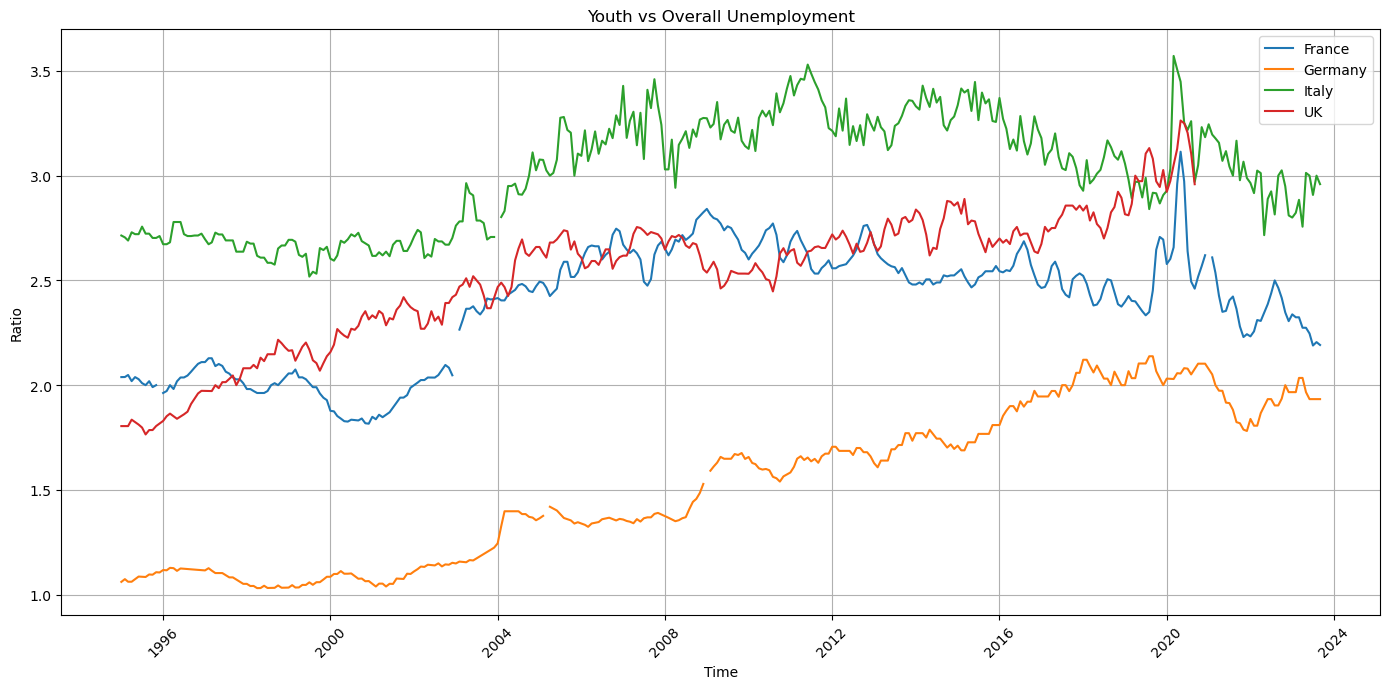

Operation 'divide' performed: 'Youth Unemployment Rate' divided by 'Overall Unemployment Rate'.


In [18]:

# Using two datasets
# manipulate_and_plot(datasets, 'Dataset1 (numerator)', 'Dataset2 (denominator)', None, 'divide', 'Title', 'X-Axis Label', 'Y-Axis Label')

# Using three datasets
# manipulate_and_plot(datasets, 'Dataset1', 'Dataset2', 'Dataset3', 'divide', 'Title', 'X-Axis Label', 'Y-Axis Label')

# examples
manipulate_and_plot(datasets, 'Youth Unemployment Rate', 'Overall Unemployment Rate', "Youth Unemployment Rate", 'divide', 'Youth vs Overall Unemployment', 'Time', 'Ratio')
manipulate_and_plot(datasets, 'Youth Unemployment Rate', 'Overall Unemployment Rate', "Youth Unemployment Rate", 'multiply', 'Youth vs Overall Unemployment', 'Time', 'Ratio')
manipulate_and_plot(datasets, 'Youth Unemployment Rate', 'Overall Unemployment Rate', None, 'divide', 'Youth vs Overall Unemployment', 'Time', 'Ratio')




# US Data

Current Working Directory:  /Users/awellman/Documents/GitHub/macrodata-wellman/macrodata-Adrien


date,value_2023-06-30,value_2023-09-30,value_2023-10-31,value_2023-11-30
name,,,,
gdppercapita,80797.776645,82356.258575,NaN,NaN
qoqgrowth,203.928121,476.276386,NaN,NaN
yoygrowth,2.354530,2.888762,NaN,NaN
prodyoygrowth,1.162153,2.216617,NaN,NaN
nomyoygrowth,5.775478,6.077809,NaN,NaN
cpiinfl,NaN,NaN,3.232356,3.021119
pceinfl,NaN,NaN,2.975170,2.746732


KeyError: 'USREC'

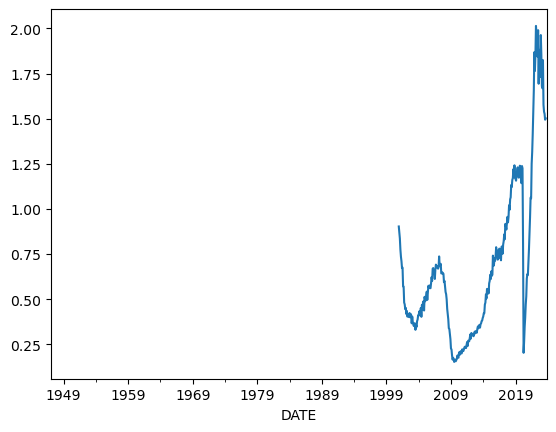

In [19]:

import os

# Define the path to the target directory
path = '/Users/awellman/Documents/GitHub/macrodata-wellman/macrodata-Adrien'

# Change the current working directory to the specified path
os.chdir(path)

# Optionally, print the current working directory to confirm the change
print("Current Working Directory: ", os.getcwd())

import data_monitor_load

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Assuming data_monitor_load.get_fred_data and data_monitor_load.decadal_average_growth are predefined functions
series = data_monitor_load.get_fred_data('Q', 'own_def')
seriesm = data_monitor_load.get_fred_data('M', 'own_def')
seriesd = data_monitor_load.get_fred_data('D', 'own_def')

def get_latest_series(ser, name):
    # Optimized function for extracting latest data points
    latest = ser.dropna().tail(2).reset_index()
    latest.columns = ['date', 'value']
    latest['name'] = name
    return latest.pivot(index='name', columns='date', values='value').rename(columns=lambda x: f'value_{x.strftime("%Y-%m-%d")}')


def plot_latest(servals, sernames):
    # Using list comprehension for efficiency
    latest_series = [get_latest_series(ser, name) for ser, name in zip(servals, sernames)]
    display(pd.concat(latest_series))


def plot_series(series, title, start_date=None, end_date=None, recession_overlay=True, label=None):
    # Centralized plotting function
    series.plot(label=label)
    yl, yh = plt.ylim()
    if recession_overlay:
        plt.fill_between(series.index, yl, yh, where=series['USREC'].values, color='k', alpha=0.1)
    if start_date and end_date:
        plt.xlim(start_date, end_date)
    plt.title(title)
    plt.legend() if label else None
    plt.show()


def calculate_growth(series, periods, annual_factor=1):
    return 100 * np.log(series).diff(periods) * annual_factor


# Economic Indicator Calculations
economic_indicators = {
    'gdppercapita': (1e6 * series['yn'] / series['pop'], 'GDP per person $'),
    'qoqgrowth': (calculate_growth(series['y'], 1, 400), 'real GDP growth QoQ'),
    'yoygrowth': (calculate_growth(series['y'], 4), 'real GDP growth YoY'),
    'prodyoygrowth': (calculate_growth(series['labprod'], 4), 'labor productivity growth YoY'),
    'nomyoygrowth': (calculate_growth(series['yn'], 4), 'nominal GDP growth YoY'),
    'cpiinfl': (100 * seriesm['cpi'].pct_change(12), 'CPI inflation'),
    'pceinfl': (100 * seriesm['pcedefl'].pct_change(12), 'PCE inflation')
    # Add other indicators as needed
}

servals = [val for val, _ in economic_indicators.values()]
sernames = [key for key, _ in economic_indicators.items()]

plot_latest(servals, sernames)

# Plotting Additional Series
plot_series(seriesm['jobopenings'] / seriesm['ulevel'], 'Vacancy/unemployment ratio', '2000-01-01', '2022-12-01')
plot_series(series['labprod'], 'Labor productivity')

# Decadal Average Growth
data_monitor_load.decadal_average_growth(series['labprod'], dec=True)

# Plotting Wage Inflation and Employment Cost Index
plot_series(seriesm['w_ces'], 'Wage inflation (CES AHE)', '2000-01-01', '2023-01-01', label='Wage inflation (CES AHE)')
plot_series(series['eci'], 'Employment cost index', '2000-01-01', '2023-01-01', label='Employment cost index', recession_overlay=False)
